In [1]:
from astropy.io import fits

import matplotlib.pyplot as plt

import numpy as np
import time
import itertools
import scipy.stats as stats

from ProbabilisticDiffusion import Diffusion
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import sys

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 256, n_steps)
        self.lin2 = ConditionalLinear(256, 512, n_steps)
        self.lin3 = ConditionalLinear(512, 256, n_steps)
        self.lin4 = nn.Linear(256, 2)
    
    def forward(self, x, y):
        x = torch.tanh(self.lin1(x, y))
        x = torch.tanh(self.lin2(x, y))
        x = torch.tanh(self.lin3(x,y))
        return self.lin4(x)


In [27]:
apogee14 = fits.open('apogee-rc-DR14.fits')
raw_data = apogee14[1].data
apogee14.info()
#To find relevant data indices for si_fe and mg_fe
#apogee14[1].header

Filename: apogee-rc-DR14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    385   29502R x 187C   [45A, 46A, 18A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, J, 140A, 14A, 3J, J, J, I, E, J, 165A, J, 74A, E, E, E, E, E, E, E, E, J, J, J, E, E, E, I, E, E, E, E, 9E, 9E, 81E, 81E, E, E, E, E, E, E, E, E, E, E, E, E, 5A, J, 183A, 9J, 26E, 26E, 26E, 26E, 26E, 26E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 26E, 26J, E, 17A, 845A, 804A, 50J, 50J, 207E, 23E, D, D, D, D, D, J, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D, D, J, D, D, D]   


## 2D Training On SI_FE(x-axis) and MG_FE(y-axis) Data

In [106]:
mg_fe = [x[80] for x in raw_data]
si_fe = [x[82] for x in raw_data]
si_fe_err = [x[107] for x in raw_data]
mg_fe_err = [x[105] for x in raw_data]
# Removes -9999.0
flag = True
while flag:
    try:
        idx = si_fe.index(-9999.0)
        del si_fe[idx]
        del mg_fe[idx]
    except ValueError:
        print('Done')
        flag = False
data = torch.stack([torch.tensor(si_fe, dtype=torch.float), torch.tensor(mg_fe, dtype=torch.float)],dim=1)
var = torch.stack([torch.tensor(si_fe_err, dtype=torch.float), torch.tensor(mg_fe_err, dtype=torch.float)],dim=1)
# Normalizing
data[:, 0] = data[:, 0]/ max(abs(data[:,0]))
data[:, 1] = data[:, 1]/ max(abs(data[:,1]))

Done


Upper Blob Portion:
2422


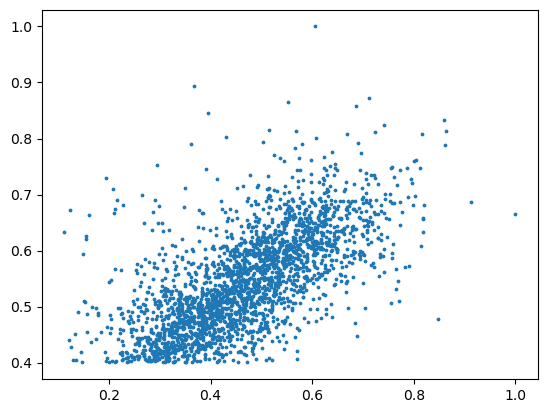

In [107]:
check = [True if i[0] > 0.1 and i[1] > 0.4 else False for i in data]
checked = data[check]
print('Upper Blob Portion:')
print(len(checked))
plt.scatter(checked[:,0], checked[:,1], s=3)
plt.show()

Lower Blob Portion:
27078


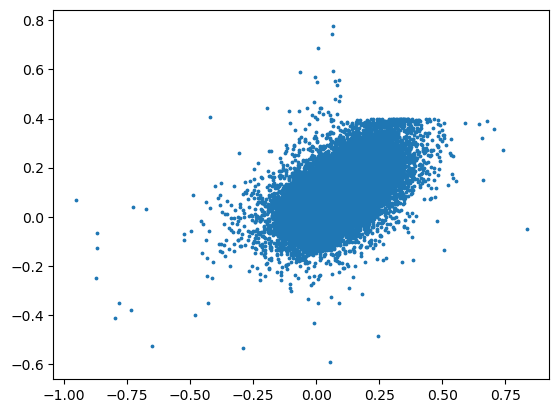

In [31]:
checked = data[~np.array(check)]
print('Lower Blob Portion:')
print(len(checked))
plt.scatter(checked[:,0], checked[:,1], s=3)
plt.show()

In [32]:
n_steps=100
model = ConditionalModel(n_steps)
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
diffusion = Diffusion(data, n_steps,
                 1e-6, 1e-2, 'linear',
                 model, loss, optimizer)

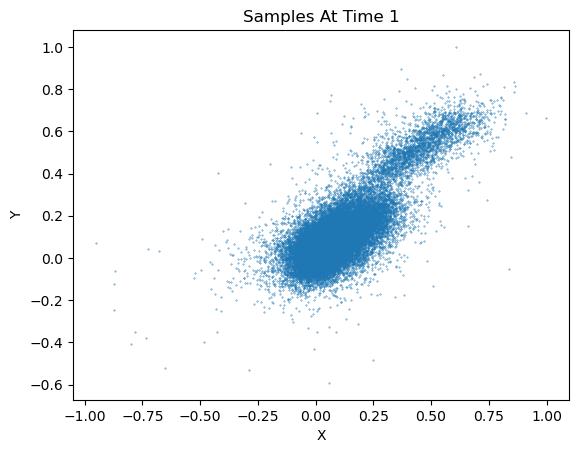

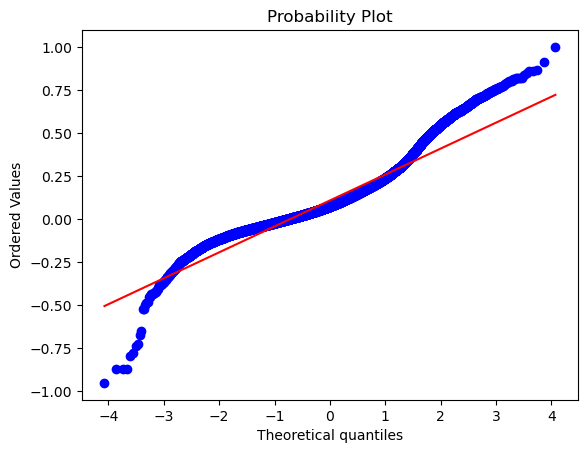

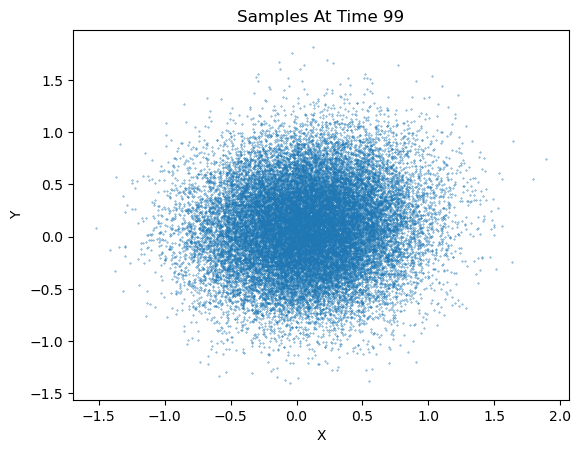

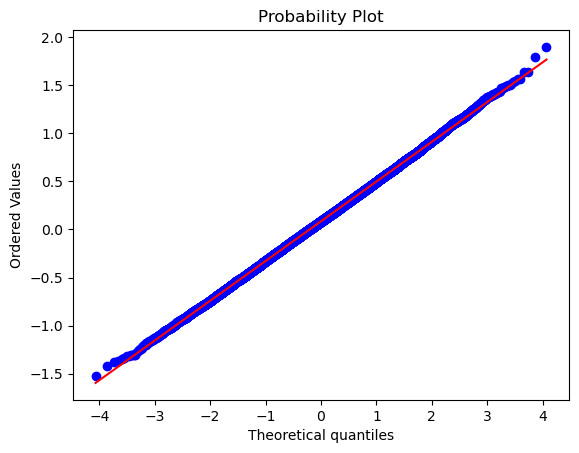

In [33]:
noised = diffusion.forward(1, s=0.1)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()
noised = diffusion.forward(99, s=0.1)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()

In [34]:
diffusion.train(10000, 1000)

  1%|▍                            | 13/1000 [00:25<31:43,  1.93s/it, loss=0.306]


KeyboardInterrupt: 

In [ ]:
new_x = diffusion.sample(10000, 50, s=3)

In [ ]:
new_x = diffusion.sample(10000, 50, no_noise=True, s=3)

## Training On All Fe Related Data

In [109]:
data_array = []
error_array = []
outliers = []
for i in range(75,100):
    print('Gathering ' + apogee14[1].header[i*2 + 8])
    fe = torch.tensor([x[i] for x in raw_data], dtype=torch.float)
    data_array.append(fe)
    err = torch.tensor([x[i+25] for x in raw_data], dtype=torch.float)
    error_array.append(err)
    # Finds -9999.0 indices for outlier removal
    #TODO:FINISH

Gathering C_FE
Gathering CI_FE
Gathering N_FE
Gathering O_FE
Gathering NA_FE
Gathering MG_FE
Gathering AL_FE
Gathering SI_FE
Gathering P_FE
Gathering S_FE
Gathering K_FE
Gathering CA_FE
Gathering TI_FE
Gathering TIII_FE
Gathering V_FE
Gathering CR_FE
Gathering MN_FE
Gathering FE_H
Gathering CO_FE
Gathering NI_FE
Gathering CU_FE
Gathering GE_FE
Gathering RB_FE
Gathering Y_FE
Gathering ND_FE


"\n# Removes -9999.0\nflag = True\nwhile flag:\n    try:\n        idx = si_fe.index(-9999.0)\n        del si_fe[idx]\n        del mg_fe[idx]\n    except ValueError:\n        print('Done')\n        flag = False\ndata = torch.stack([torch.tensor(si_fe, dtype=torch.float), torch.tensor(mg_fe, dtype=torch.float)],dim=1)\nvar = torch.stack([torch.tensor(si_fe_err, dtype=torch.float), torch.tensor(mg_fe_err, dtype=torch.float)],dim=1)\n# Normalizing\ndata[:, 0] = data[:, 0]/ max(abs(data[:,0]))\ndata[:, 1] = data[:, 1]/ max(abs(data[:,1]))"